## Import necessary python modules

In [2]:
import multiprocessing
from copy import deepcopy as dc
from os import path
from typing import Tuple

import import_ipynb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from helpful_functions import *
from streakimage import StreakImage
import find_outliers

## Load source files

In [3]:
folder = "./files/camera_correction/"

The following cell loads six files (one for each time range) and their backgrounds. Inside the loops Python's f-string are used. *f* stands for *format*. A string variable wrapped in braces is replaced by its value.

In [4]:
bg_dict = {}

for tr in range(1, 7):
    bg_dict[f"bg_ST{tr}_g10_100x2002ms"] = StreakImage(
        path.join(folder, f"corr file bg gain10 ST{tr} 100x2s.img")
    )

img_dict = {}

for tr in range(1, 7):
    img_dict[f"ST{tr}_correction"] = StreakImage(
        path.join(folder, f"corr file slit60 gain10 ST{tr} 100x2s.img"),
        bg_dict=bg_dict,
        title=f"ST{tr} corr",
    )

## Plot images

In [4]:
def get_mean(df: pd.DataFrame, poi: Tuple[int]) -> Tuple[float]:
    """
    Returns the mean and standard deviation of df without poi.
    """
    values = [val for ar in df.values for val in ar]
    values.remove(
        df.iloc[poi]
    )  # remove value of point of interest, only once if contained multiple times
    val_array = np.array(values)
    return (val_array.mean(), val_array.std())


def find_outliers(df: pd.DataFrame, stdev_factor=4.0, window_size: int = 2):
    """
    Finds ouliers and replace them with the mean value of their environment.

    Each cell in the dataframe is compared to its environment. The environment comprises the window_size rows and columns arround the cell.
    The mean of the environment (without the value of the cell) is calculated and if the value of the cell deviated more than stdev_factor standard deviations from that mean, it is replaced by the mean.

    Parameters:
        df (pd.DataFrame): The DataFrame to digest.
        stdev_factor (float): The factor for the standard deviation.
        window_size (int): The size of the environment.
    """
    df_new = dc(df)
    for idx in range(0, df.shape[0]):
        #         print(df.index[idx],"\n")
        for col in range(0, df.shape[1]):
            #             print(df.columns[col])
            a = idx - window_size if idx - window_size > 0 else 0
            b = idx + window_size + 1
            c = col - window_size if col - window_size > 0 else 0
            d = col + window_size + 1
            subset = df.iloc[a:b, c:d]

            poi = (
                idx if idx < window_size else window_size,
                col if col < window_size else window_size,
            )
            env_mean, env_std = get_mean(subset, poi)

            #             print(poi)
            #             print(subset)
            #             print("")
            #             print(df.iloc[idx,col],env_mean, env_std)
            if (
                df.iloc[idx, col]
                > max(
                    env_mean + (env_std * stdev_factor),
                    env_mean - (env_std * stdev_factor),
                )
                or df.iloc[idx, col]
                < min(
                    env_mean + (env_std * stdev_factor),
                    env_mean - (env_std * stdev_factor),
                )
                or df.iloc[idx, col] < 0
            ):
                df_new.iloc[idx, col] = env_mean
    #         print("")
    return df_new

In [5]:
# def filter_col(
#     df: pd.DataFrame,
#     df_new: pd.DataFrame,
#     stdev_factor: float,
#     window_size: int,
#     idx: int,
#     col: int,
# ):

#     #     logging.info("Thread %s: starting", f'row{idx}col{col}')
#     #     s = idx,col
#     #     print(s)
#     a = idx - window_size if idx - window_size > 0 else 0
#     b = idx + window_size + 1
#     c = col - window_size if col - window_size > 0 else 0
#     d = col + window_size + 1
#     subset = df.iloc[a:b, c:d]

#     poi = (
#         idx if idx < window_size else window_size,
#         col if col < window_size else window_size,
#     )
#     env_mean, env_std = get_mean(subset, poi)

#     if (
#         df.iloc[idx, col]
#         > max(
#             env_mean + (env_std * stdev_factor),
#             env_mean - (env_std * stdev_factor),
#         )
#         or df.iloc[idx, col]
#         < min(
#             env_mean + (env_std * stdev_factor),
#             env_mean - (env_std * stdev_factor),
#         )
#         or df.iloc[idx, col] < 0
#     ):
#         df_new.iloc[idx, col] = env_mean


# def filter_row_mt(
#     df: pd.DataFrame,
#     df_new: pd.DataFrame,
#     stdev_factor: float,
#     window_size: int,
#     idx: int,
# ):
#     #     logging.info("Thread %s: starting", f'row{idx}')

#     #     args = (
#     #         (df, df_new, stdev_factor, window_size, idx, col)
#     #         for col in range(0, 100)#df.shape[1])
#     #     )
#     #     with concurrent.futures.ThreadPoolExecutor(max_workers=10) as excecutor:
#     #         excecutor.map(lambda p: filter_col(*p), args)

#     #     logging.info("Thread %s: finishing", f'row{idx}')

#     for col in range(0, 3):  # df.shape[1]):
#         filter_col(
#             df=df,
#             df_new=df_new,
#             stdev_factor=stdev_factor,
#             window_size=window_size,
#             idx=idx,
#             col=col,
#         )


# def find_outliers_mt(
#     df: pd.DataFrame, stdev_factor=4.0, window_size: int = 2, name=None
# ):
#     """
#     Finds ouliers and replace them with the mean value of their environment.

#     Each cell in the dataframe is compared to its environment. The environment comprises the window_size rows and columns arround the cell.
#     The mean of the environment (without the value of the cell) is calculated and if the value of the cell deviated more than stdev_factor standard deviations from that mean, it is replaced by the mean.

#     Parameters:
#         df (pd.DataFrame): The DataFrame to digest.
#         stdev_factor (float): The factor for the standard deviation.
#         window_size (int): The size of the environment.
#     """
#     df_new = dc(df)
#     logging.info("Thread %s: starting", f'row{idx}')
#     for idx in range(0, 2):  # df.shape[0]):
#         filter_row_mt(
#             df=df,
#             df_new=df_new,
#             stdev_factor=stdev_factor,
#             window_size=window_size,
#             idx=idx,
#         )
#     logging.info("Thread %s: finishing", f'row{idx}')
#     df = df_new

In [6]:
%%timeit
img_dict_corr = dc(img_dict)
for key in img_dict_corr:
    img_dict_corr[key].data = find_outliers_mt(
        img_dict_corr[key].data, stdev_factor=4, window_size=2, name=key
    )

28.9 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit

img_dict_corr = dc(img_dict)
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")

args = ((img_dict_corr[key].data, 4, 2, key) for key in img_dict_corr)

with concurrent.futures.ThreadPoolExecutor(max_workers=1) as excecutor:
    excecutor.map(lambda p: find_outliers_mt(*p), args)

13.1 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit

img_dict_corr = dc(img_dict)
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")

args = ((img_dict_corr[key].data, 4, 2, key) for key in img_dict_corr)

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as excecutor:
    excecutor.map(lambda p: find_outliers_mt(*p), args)

13.8 s ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

img_dict_corr = dc(img_dict)
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")

args = ((img_dict_corr[key].data, 4, 2, key) for key in img_dict_corr)
jobs = []

for args_ in args:

    p = multiprocessing.Process(target=test_xx, args=args_)
    jobs.append(p)
    p.start()

for job in jobs:
    job.join()

# with concurrent.futures.ThreadPoolExecutor(max_workers=6) as excecutor:
#     excecutor.map(lambda p: find_outliers_mt(*p), args)

In [8]:
%%time

img_dict_corr = dc(img_dict)

if __name__ == "__main__":
    num_processors = 6
    p = multiprocessing.Pool(processes=num_processors)
    args = ((img_dict_corr[key], 4, 2, key) for key in img_dict_corr)
    output = p.map(
        find_outliers.find_outliers_mp, args
    )
    for tpl in output:
        img_dict_corr[tpl[0]]=tpl[1]

Wall time: 1min


In [17]:
if __name__ == "__main__":
    num_processors = 6
    intvar = 0
    p = multiprocessing.Process(target=find_outliers.find_outliers_mp, args=(intvar,)
    )
    p.start()
    p.join()
    print(intvar)

0


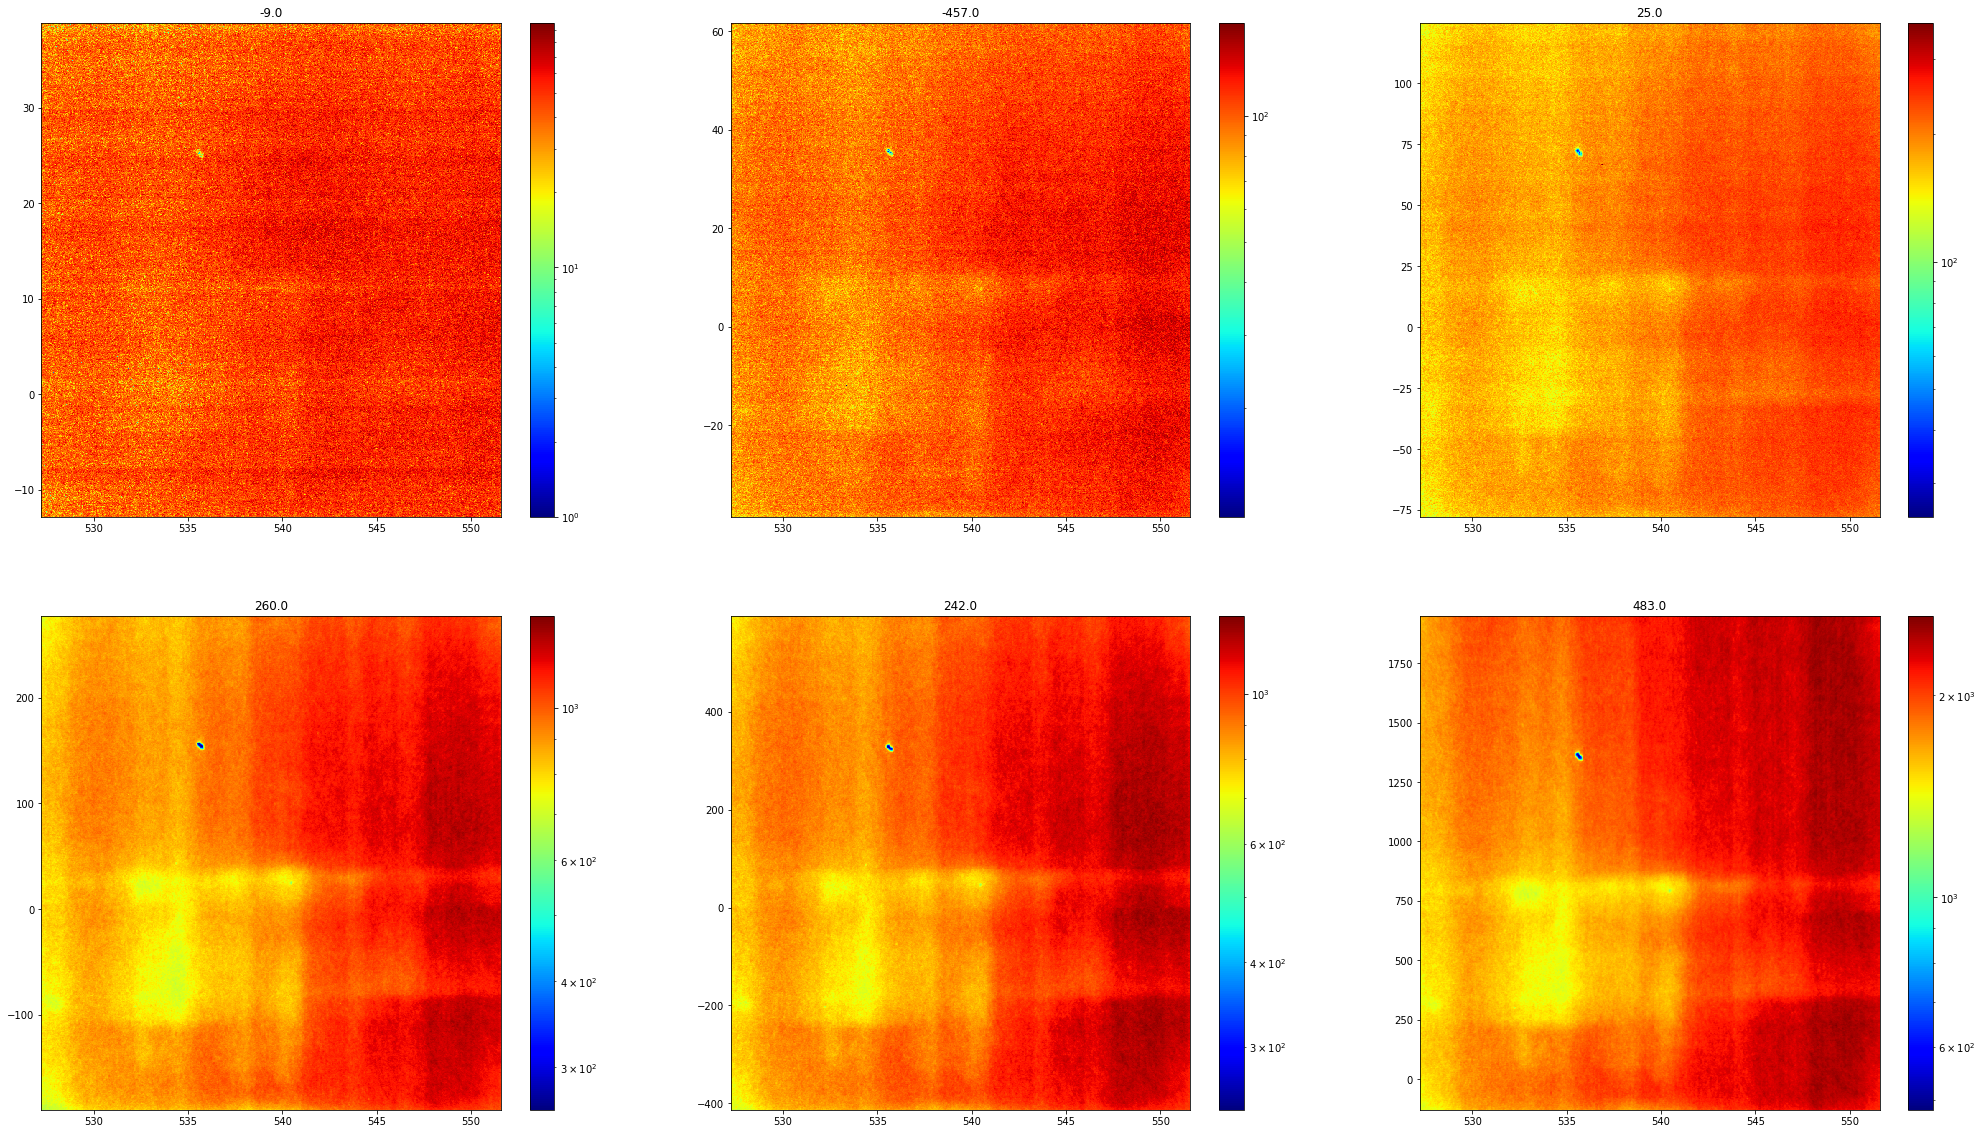

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes for ax in row]
axes_iter = iter(axes_list)

for key in img_dict:
    img = img_dict[key]
    ax = next(axes_iter)
    plot_heatmap(df=img.data, fig=fig, ax=ax, title=img.data.min().min())

In [6]:
%%time
img_dict_corr = dc(img_dict)
for key in img_dict_corr:
    img_dict_corr[key].data = find_outliers(
        img_dict_corr[key].data, stdev_factor=4, window_size=2
    )

Wall time: 5min 23s


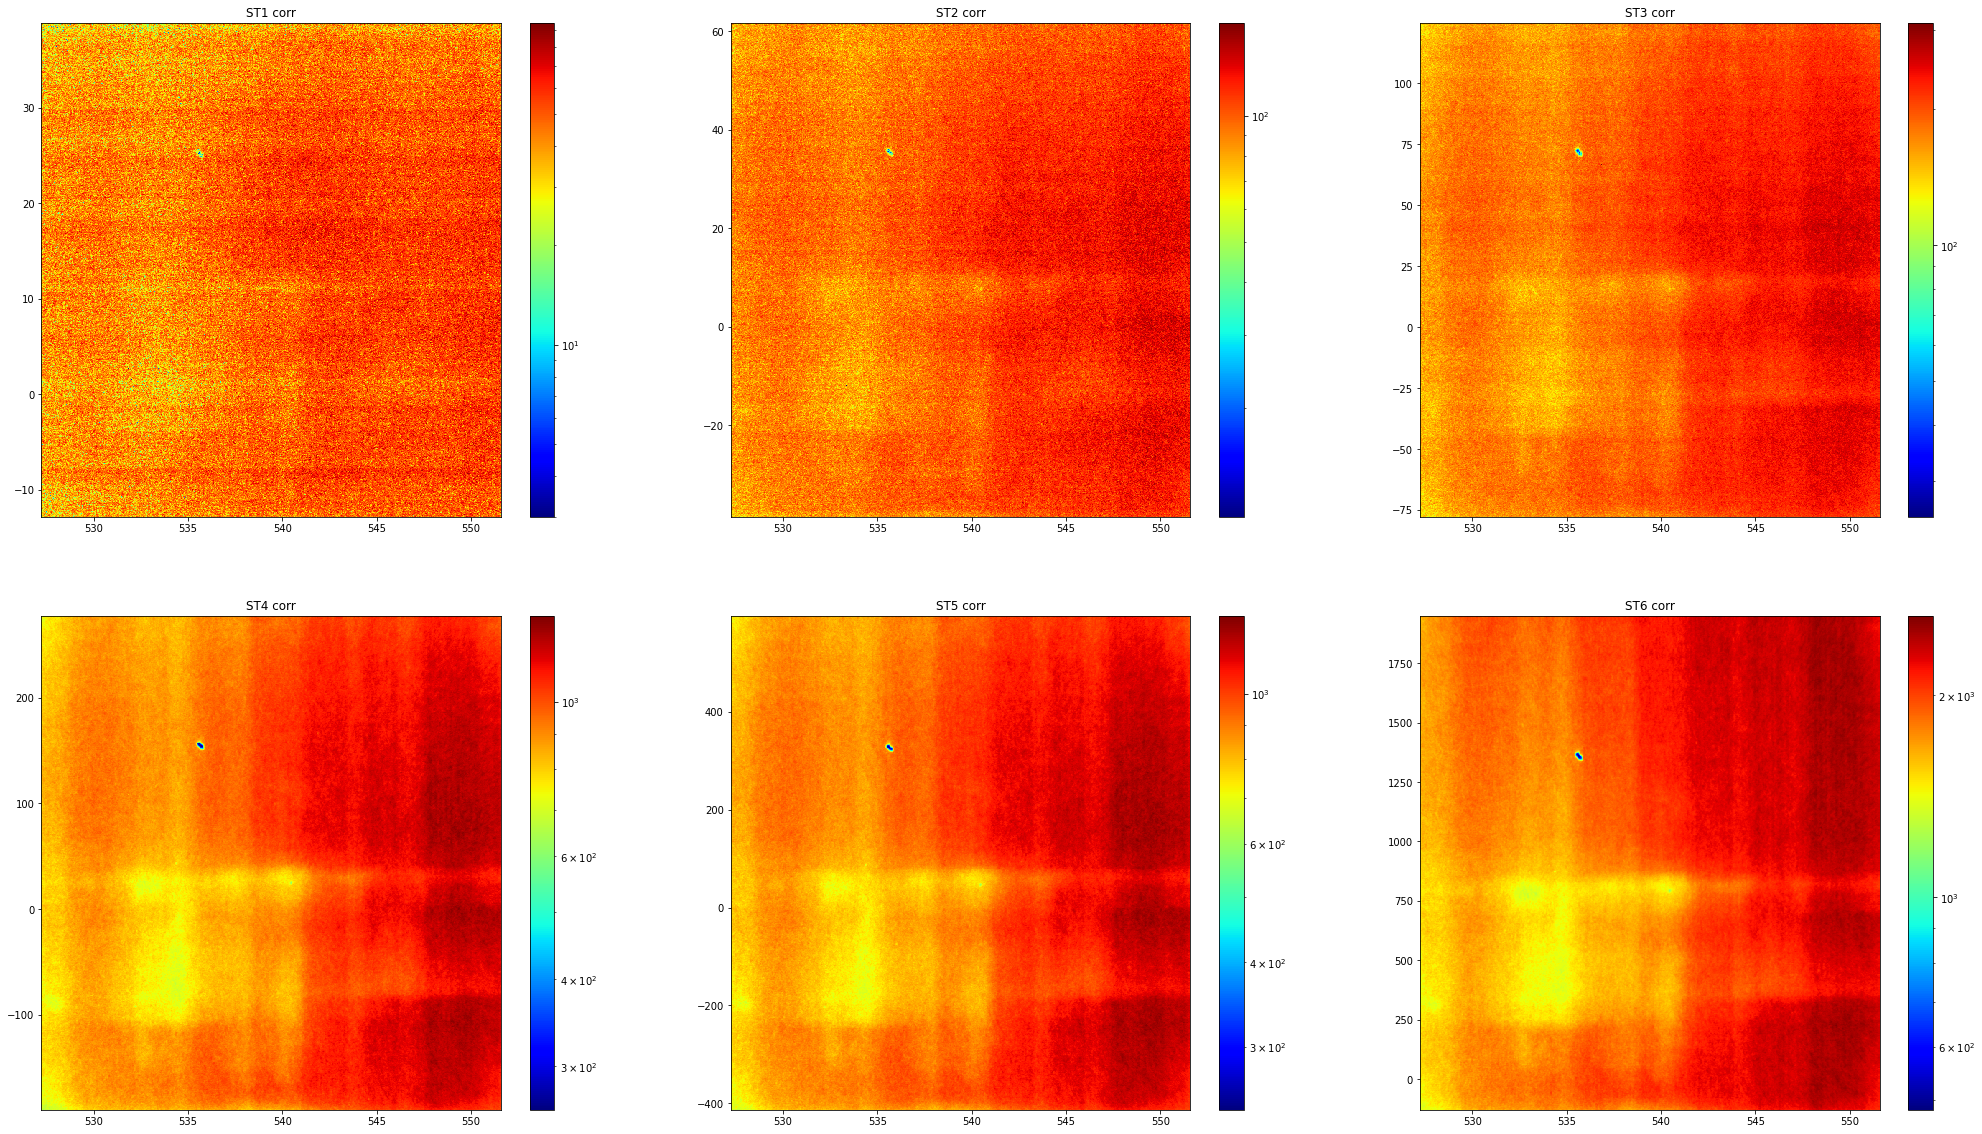

In [7]:
fig_corr, axes_corr = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_corr for ax in row]
axes_iter = iter(axes_list)

for key in img_dict_corr:
    img = img_dict_corr[key]
    ax = next(axes_iter)
    plot_heatmap(df=img.data, fig=fig_corr, ax=ax, title=img.title)

## Check Dead Pixel (position may change)

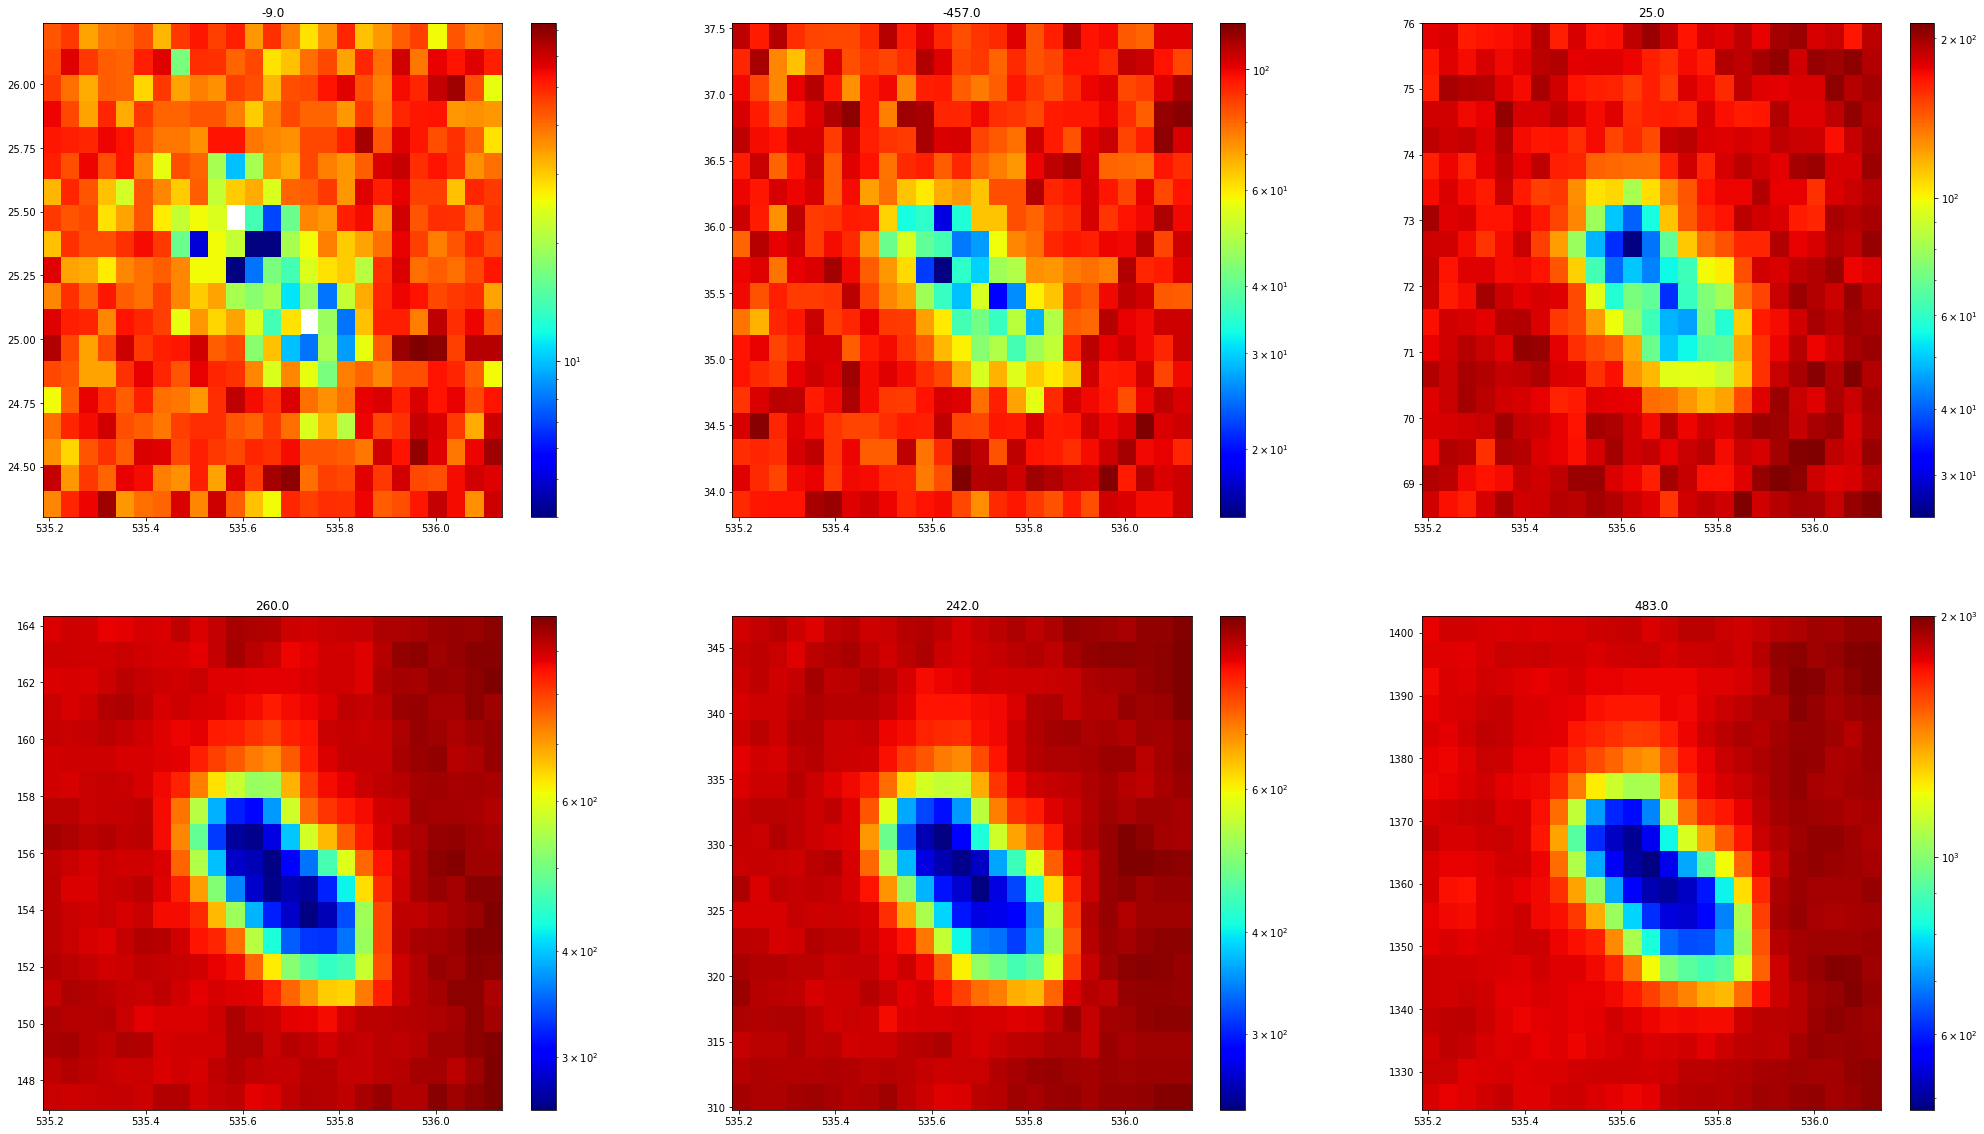

In [4]:
fig_zoom, axes_zoom = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_zoom for ax in row]
axes_iter = iter(axes_list)

for key in img_dict:
    img = img_dict[key]
    ax = next(axes_iter)
    plot_heatmap(
        df=img.data.iloc[370:389, 209:234],
        fig=fig_zoom,
        ax=ax,
        title=img.data.min().min(),
    )

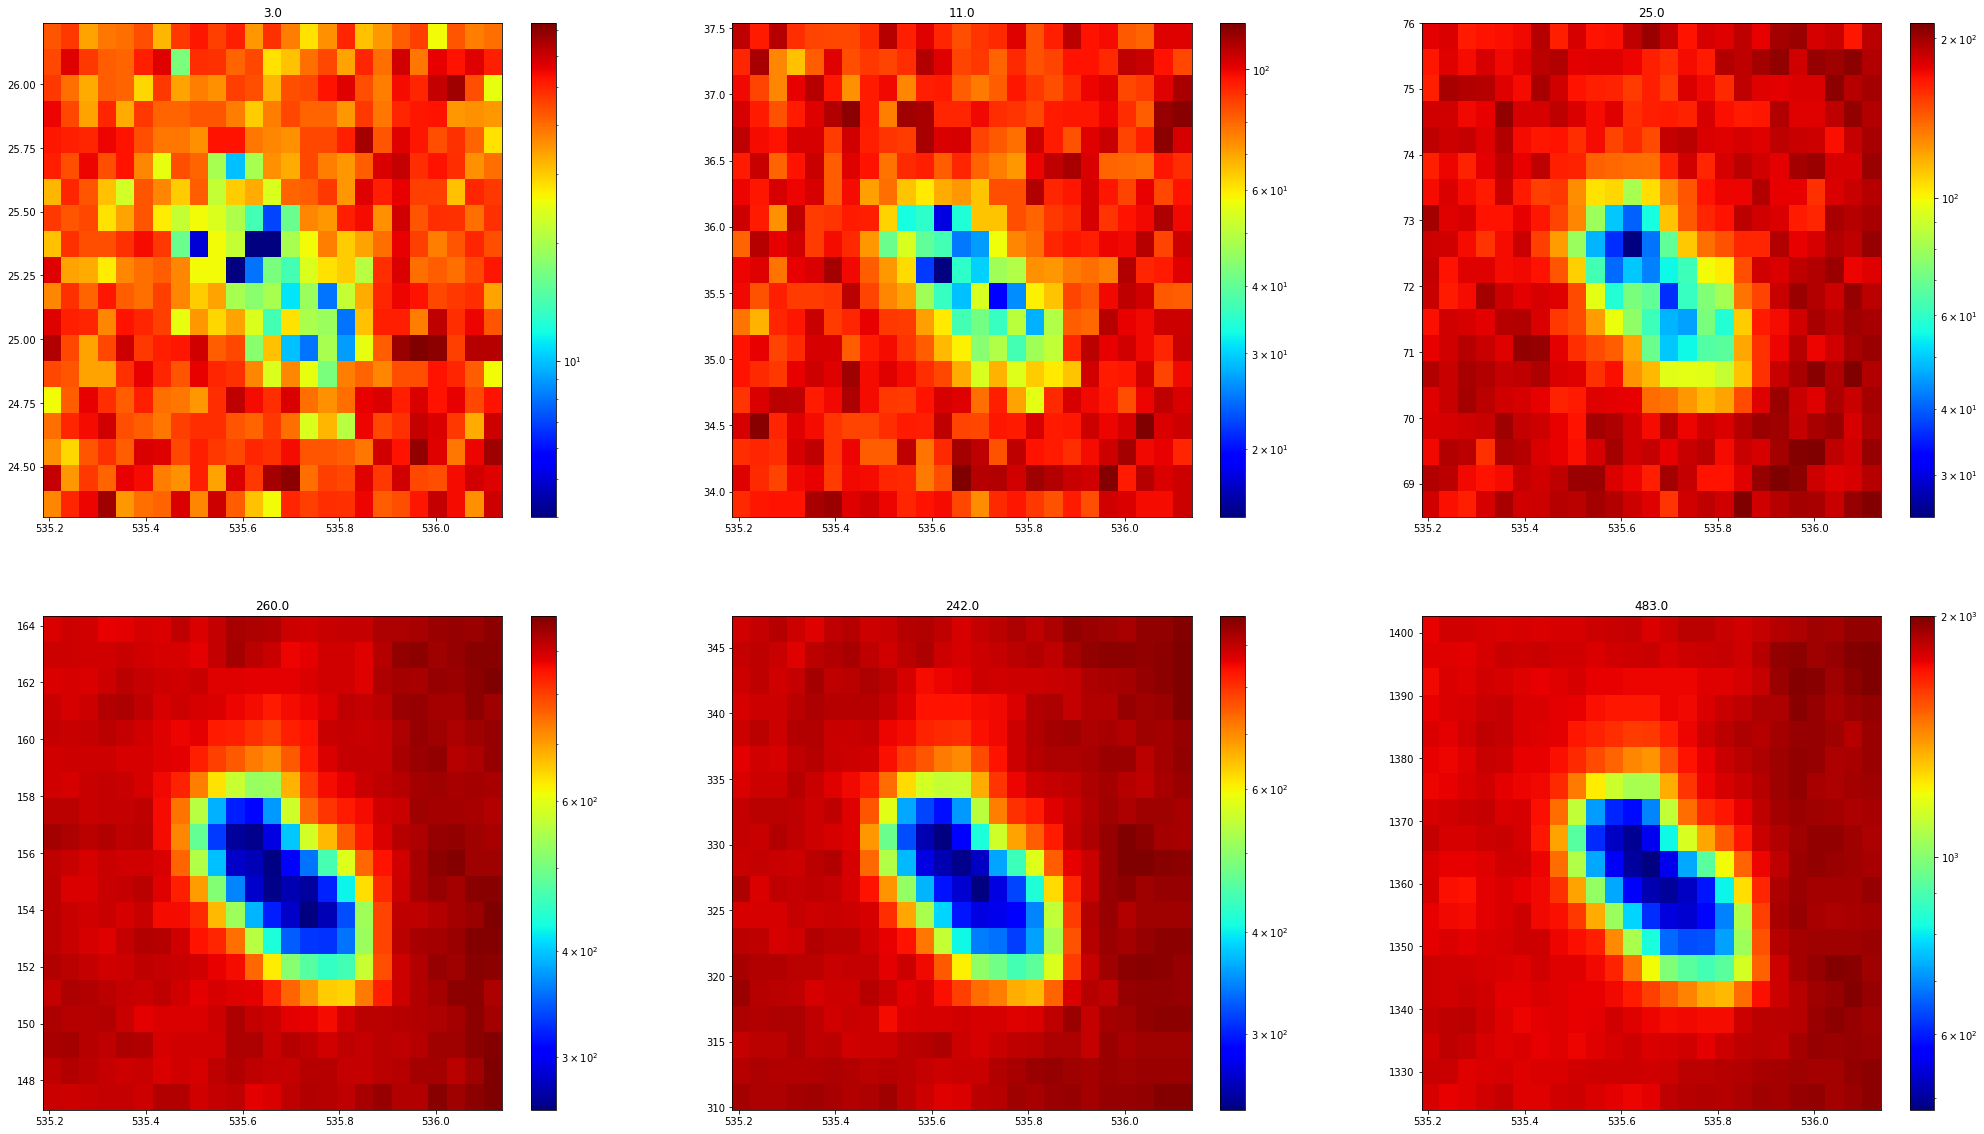

In [9]:
fig_zoom, axes_zoom = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_zoom for ax in row]
axes_iter = iter(axes_list)

for tpl in output:
    img = tpl[1]
    ax = next(axes_iter)
    plot_heatmap(
        df=img.data.iloc[370:389, 209:234],
        fig=fig_zoom,
        ax=ax,
        title=img.data.min().min(),
    )

AttributeError: 'DataFrame' object has no attribute 'data'

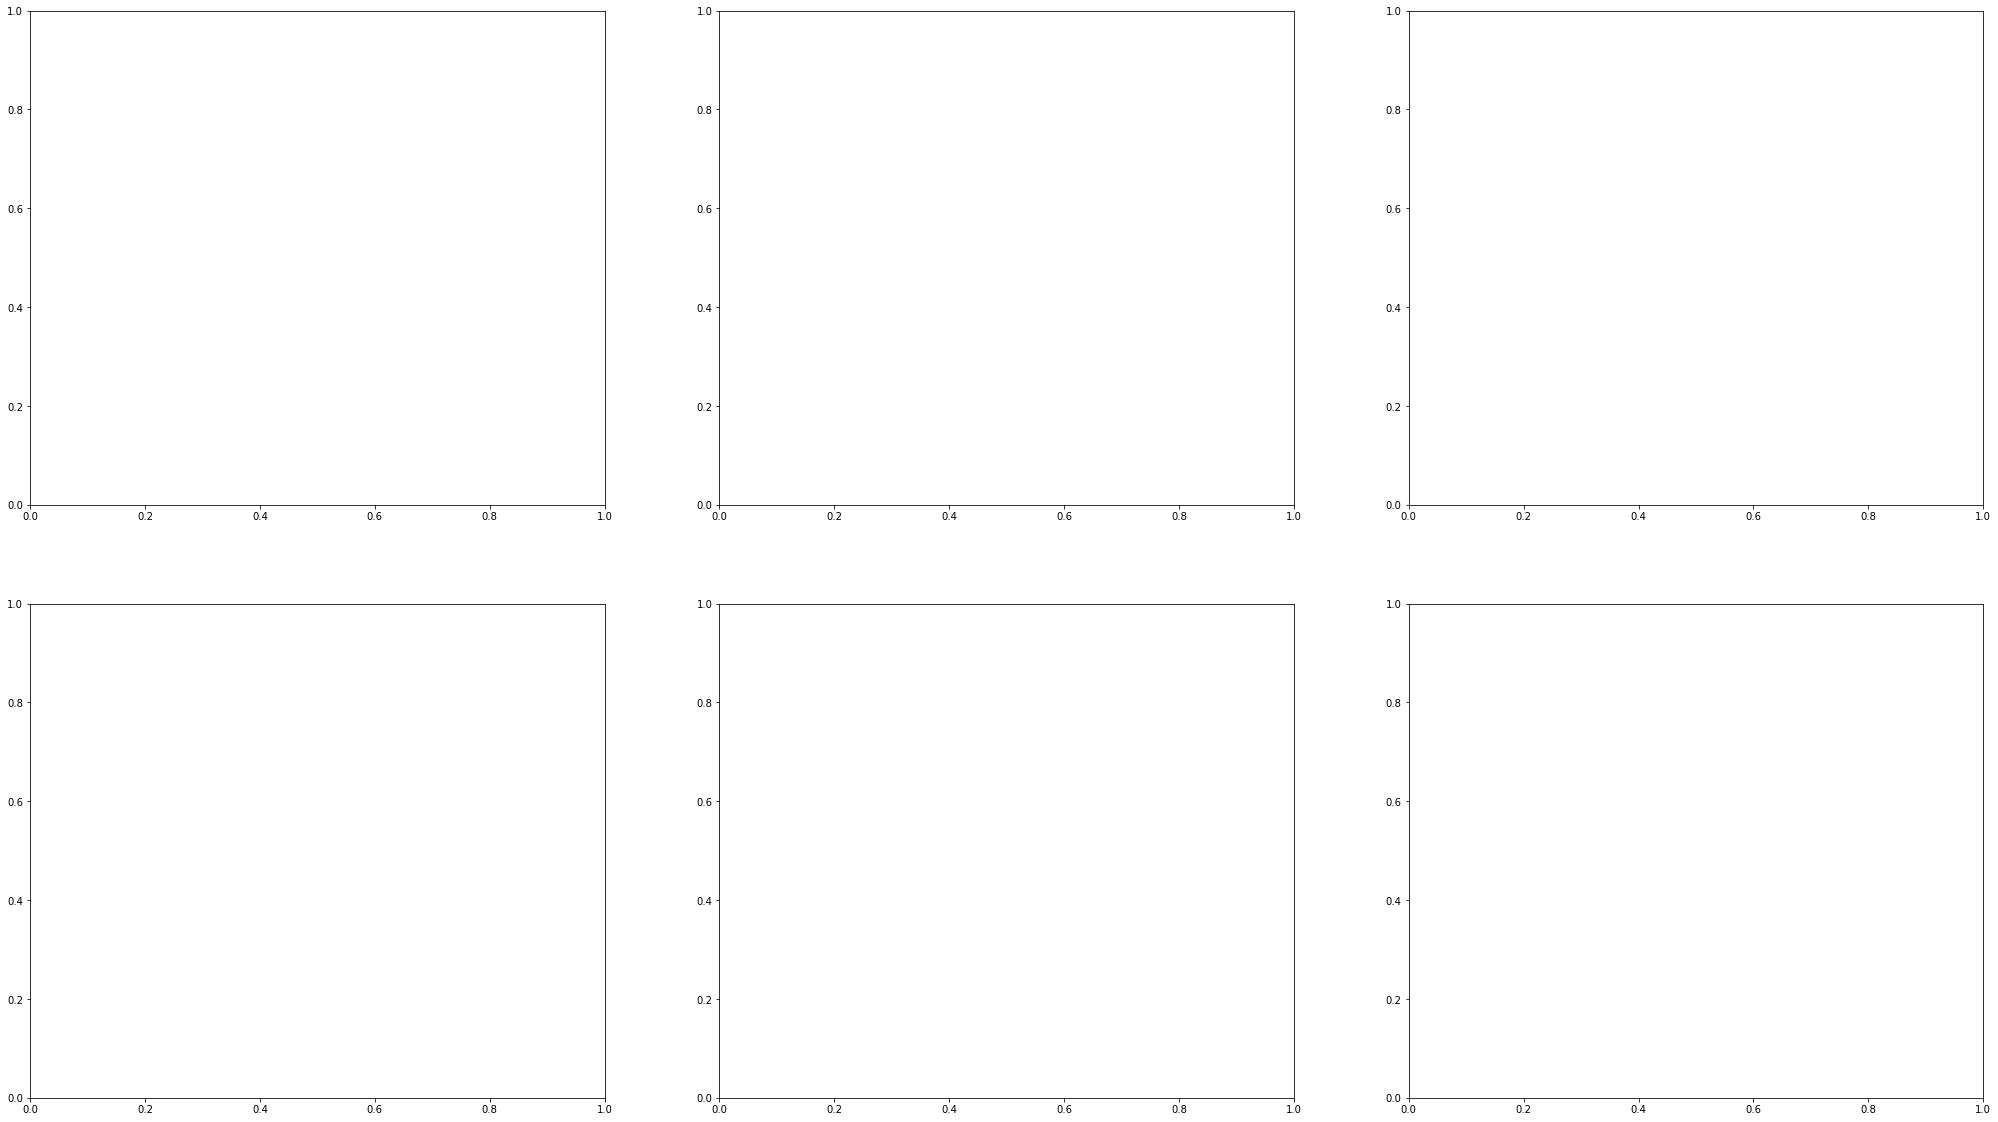

In [13]:
fig_corr_zoom, axes_corr_zoom = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_corr_zoom for ax in row]
axes_iter = iter(axes_list)

for key in img_dict_corr:
    img = img_dict_corr[key]
    ax = next(axes_iter)
    plot_heatmap(
        df=img.data.iloc[370:389, 209:234], fig=fig_corr_zoom, ax=ax, title=img.title
    )

### Export before and after pictures for comparison

In [11]:
# fig.savefig("./blob/uncorrected.png")
# fig_corr.savefig("./blob/corrected.png")

# fig_zoom.savefig("./blob/zoom_uncorrected.png")
# fig_corr_zoom.savefig("./blob/zoom_corrected.png")

## Normalize data

Check histogram

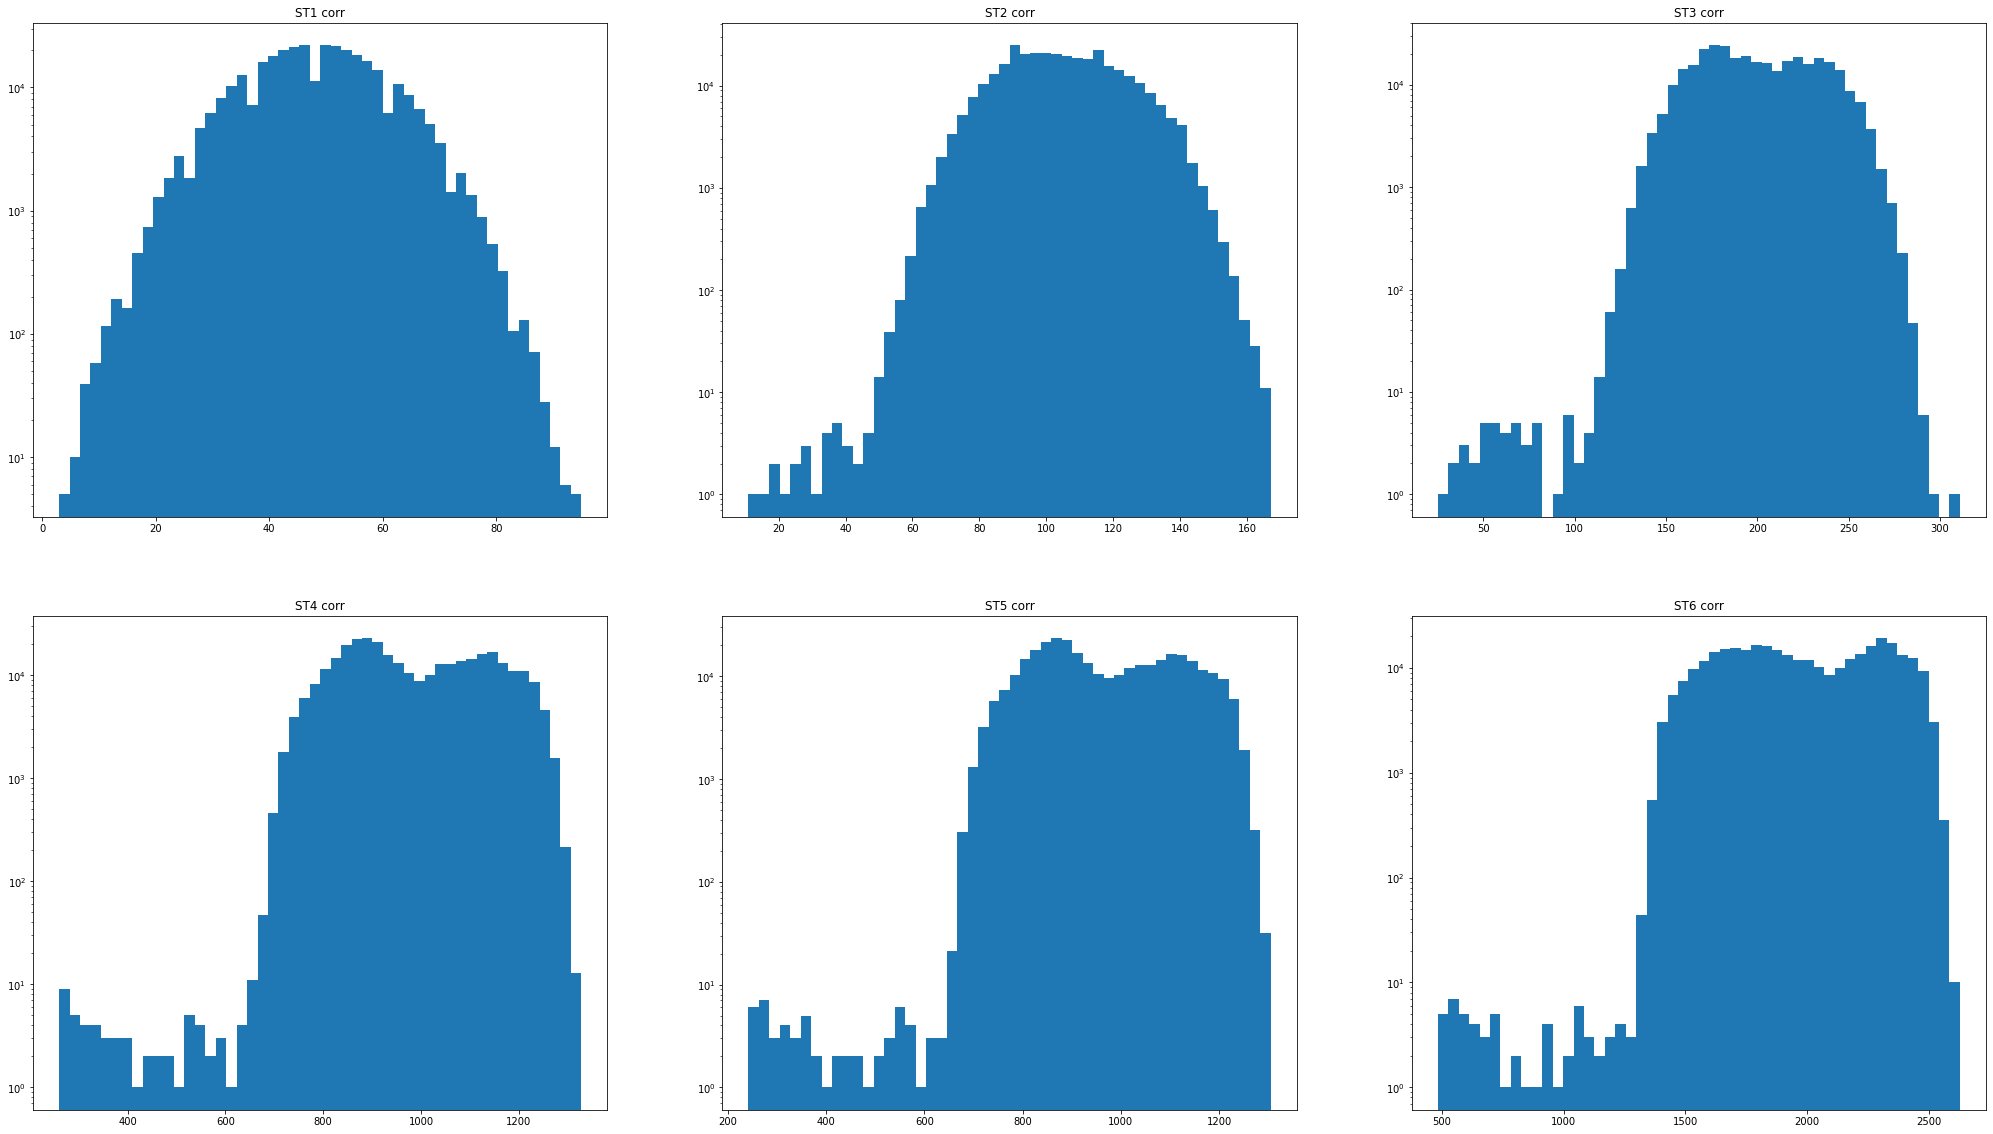

In [36]:
fig_hist, axes_hist = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_hist for ax in row]
axes_iter = iter(axes_list)

for key in img_dict_corr:
    img = img_dict_corr[key]

    vals = [val for ar in img.data.values for val in ar]

    ax = next(axes_iter)
    n, bins, patches = ax.hist(vals, bins=50)
    ax.set_title(img.title)
    ax.set_yscale("log")

In [38]:
img_dict_corr_norm = dc(img_dict_corr)
for key in img_dict_corr_norm:
    df = img_dict_corr_norm[key].data
    df_max = df.max().max()
    #     df_min = df.min().min()
    #     df_mean = df.mean().mean()
    img_dict_corr_norm[key].data /= df_max
#     img_dict[key].data = df/df_mean

## Plot normalized data

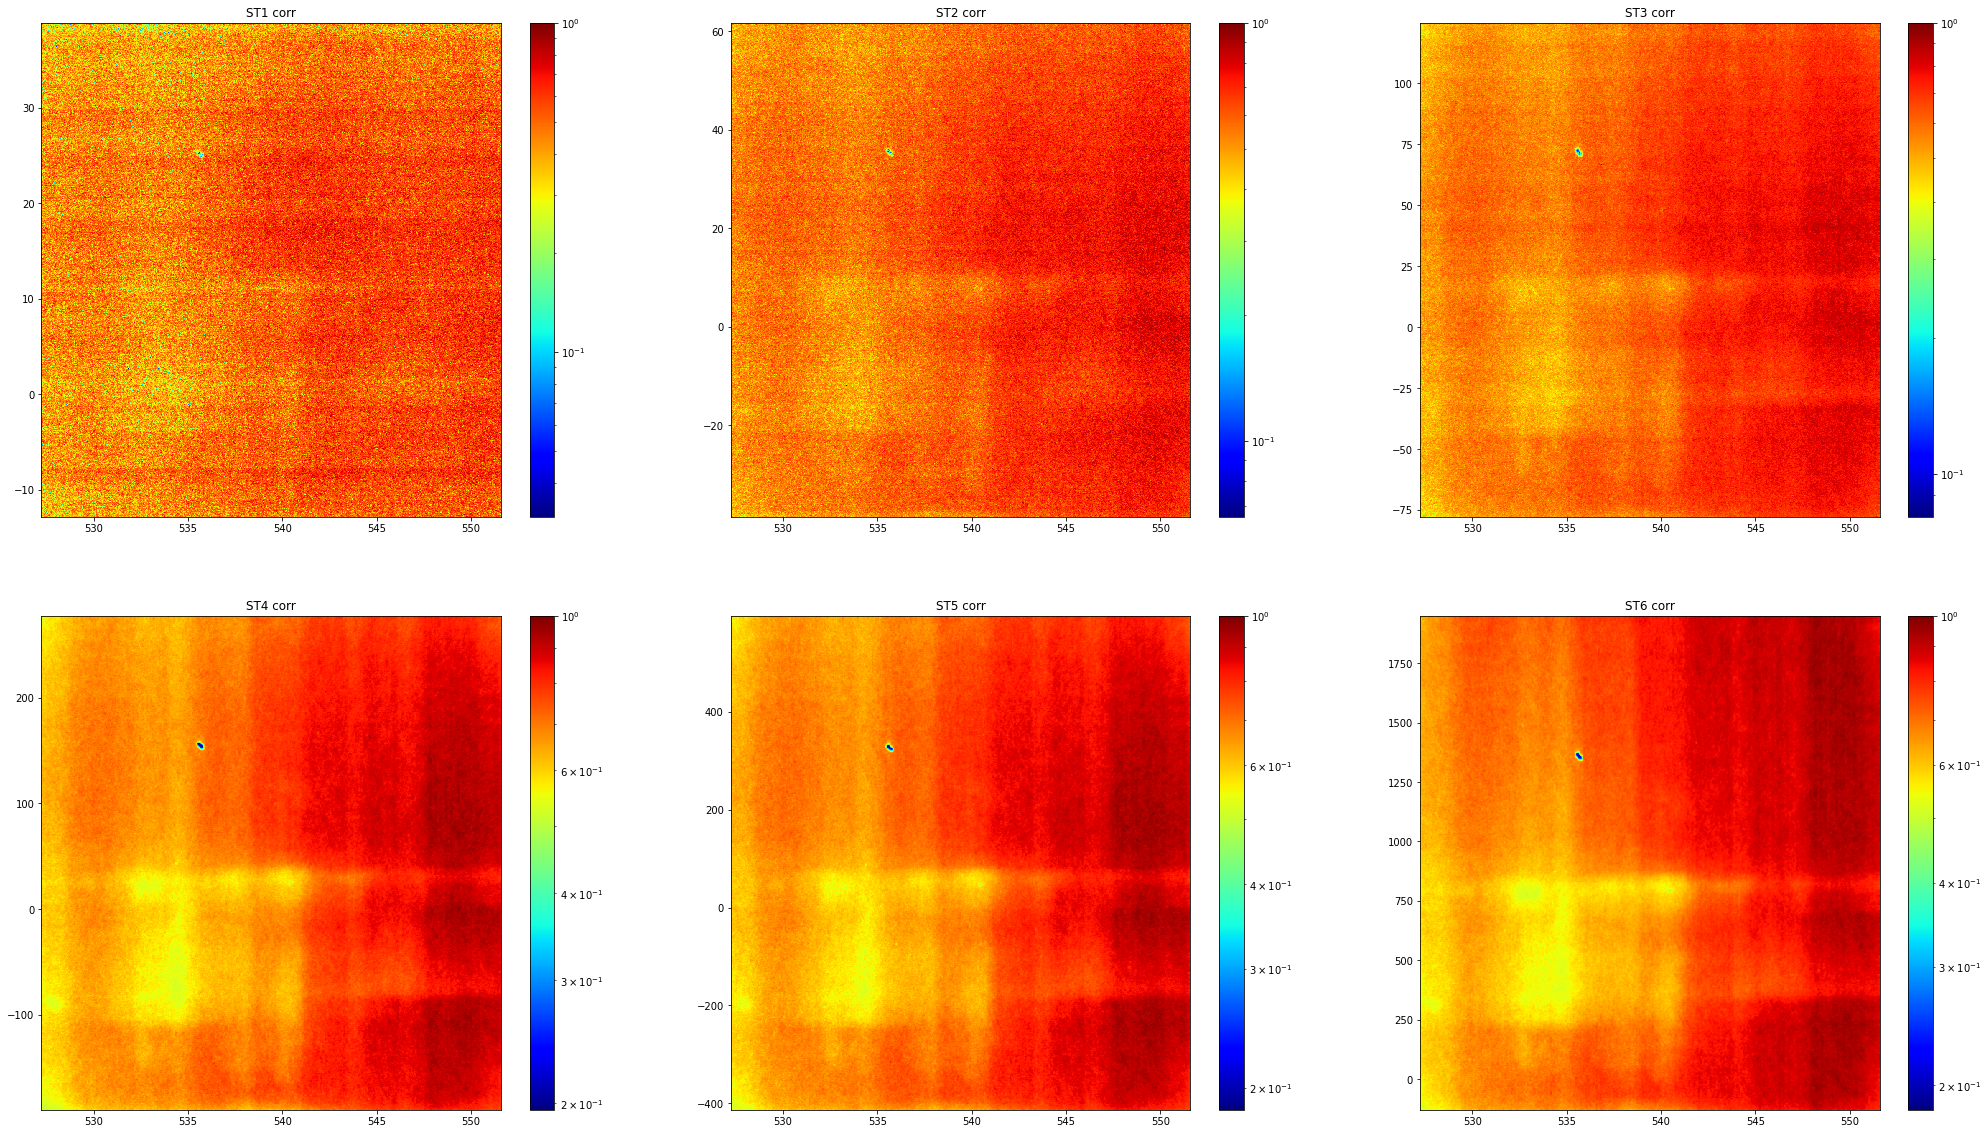

In [40]:
fig_norm, axes_norm = plt.subplots(2, 3, figsize=(35, 20))
axes_list = [ax for row in axes_norm for ax in row]
axes_iter = iter(axes_list)

for key in img_dict_corr_norm:
    img = img_dict_corr_norm[key]
    ax = next(axes_iter)
    plot_heatmap(df=img.data, fig=fig_norm, ax=ax, title=img.title)

## Test corrections - WIP

Load files to test the corrections on. This is another series of white light images.

In [ ]:
WIP

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_list = [ax for row in axes for ax in row]
axes_iter = iter(axes_list)

## Export matrices as NumPy files
Note: All information about the original image, including the x- and y-axes, will be ommited.

In [ ]:
prefix = "202004"  # A unique id for the correction matrix. The simplest aproach is to use the year and month of the image but any arbitrary id is possible.
folder = "./files/camera_correction/"
for key in img_dict:
    img = img_dict[key]
    path_ = path.join(folder, f"{prefix}_{key}_{img.width}x{img.height}")
    np.save(path_, img.data.values)

Refer to the README of [StreakImage](https://github.com/nicohofdtz/streakimage) for information on where to place the created correction files and how to include them in the config.